In [ ]:
library(coloc)
library(LDlinkR)
library(tidyverse)
library(data.table)
library(parallel)
library(GenomicRanges)
library(rtracklayer)
library(locuszoomr)
library(EnsDb.Hsapiens.v75)
library(ggpubr)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(gridExtra)
library(cowplot)
library(patchwork)

In [2]:
gene_id_name = fread('/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/gene_randmol_lookup.csv', sep='\t')
print(dim(gene_id_name))
head(gene_id_name)

[1] 5121    3


GENEID,GENENAME,MOLID
<chr>,<chr>,<chr>
ENSG00000188976,NOC2L,ILMN_1792820
ENSG00000187608,ISG15,ILMN_2054019
ENSG00000186827,TNFRSF4,ILMN_1710204
ENSG00000078808,SDF4,ILMN_1696065
ENSG00000131584,ACAP3,ILMN_1743847
ENSG00000127054,CPSF3L,ILMN_1718013


In [3]:
celltype_map = list(B=c('bin', 'bmem', 'plasma'),
                    CD4T=c('cd4et', 'cd4nc', 'cd4sox4'),
                    CD8T=c('cd8et', 'cd8nc', 'cd8s100b'),
                    NK=c('nk', 'nkr'),
                    monocyte=c('monoc', 'mononc'),
                    DC=c('dc'))
sorted_cell_names = c('B', 'CD4', 'CD8', 'NK', 'Monocyte', 'DC')

# IBD

## Run coloc

In [4]:
sumstats <- fread('/data2/xiaojiashun/eQTL/data/blood_coloc/gwas/RA-10-28-2021/EUR_all_auto-10-2021_processed.txt.gz') %>% 
  mutate(CHR=paste0('chr', CHR), beta=Beta, se=SE) %>% 
  dplyr::filter(!is.na(Pval)) %>% 
  dplyr::select(variant_id=SNP,p_value=Pval,chr=CHR,bp_b37=BP,effect_allele=alt,other_allele=ref,beta,se)
dim(sumstats)
head(sumstats)

[1] 8919817       8

variant_id,p_value,chr,bp_b37,effect_allele,other_allele,beta,se
<chr>,<dbl>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>
rs202152658,0.1220,chr1,751343,A,T,-0.0588,0.0380
rs143225517,0.1230,chr1,751756,C,T,-0.0585,0.0379
rs3094315,0.1495,chr1,752566,A,G,0.0472,0.0328
rs3131972,0.2354,chr1,752721,G,A,0.0325,0.0274
rs3131971,0.1439,chr1,752894,C,T,0.0522,0.0357
rs61770173,0.1333,chr1,753405,A,C,0.0554,0.0369


In [5]:
if(file.exists('/data2/xiaojiashun/eQTL/data/blood_coloc/gwas/ra/loci_LDlinkR.r2.0.1.EUR.txt')){
    loci <- fread('/data2/xiaojiashun/eQTL/data/blood_coloc/gwas/ra/loci_LDlinkR.r2.0.1.EUR.txt', sep='\t')
}
closest <- fread(paste0('/data2/xiaojiashun/eQTL/data/blood_coloc/gwas/ra/closest.protein.coding.bed'),sep='\t', header=FALSE) %>% 
  setNames(c('chr_snp','start_snp','end_snp','GWAS_snp','beta','chr_gene','start_gene','end_gene','gene','distance')) %>% 
  mutate(GWAS_snp_pos=paste0(chr_snp,':',start_snp)) %>% 
  dplyr::select(GWAS_snp,GWAS_snp_pos,gene,beta,distance) %>% 
  separate(gene,into=c('symbol','ensembl'),sep='_') %>% 
  add_count(GWAS_snp) %>% 
  group_by(GWAS_snp) %>% 
  mutate(locus_name_gene=ifelse(n==1,symbol,paste0(symbol,collapse=' - '))) %>% 
  ungroup() %>% 
  dplyr::select(GWAS_snp_pos,locus_name_gene,beta_top_GWAS=beta) %>% 
  unique() %>% arrange(-abs(beta_top_GWAS))
loci <- left_join(loci,closest,by='GWAS_snp_pos')
dim(loci)
head(loci)

[1] 69  8

GWAS_snp,GWAS_snp_pos,locus_name,chrom,start,end,locus_name_gene,beta_top_GWAS
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>
rs867435,chr1:2523706,chr1:2407781_2779397,chr1,2407781,2779397,MMEL1,-0.0912
rs2240336,chr1:17674402,chr1:17599149_17677665,chr1,17599149,17677665,PADI4 - AC004824.2,-0.0856
rs2045793,chr1:38635462,chr1:38606400_38696216,chr1,38606400,38696216,POU3F1,-0.0971
rs6659932,chr1:67802371,chr1:67769682_67940286,chr1,67769682,67940286,IL12RB2,-0.1019
rs2476601,chr1:114377568,chr1:113910209_114547798,chr1,113910209,114547798,PTPN22,-0.5439
rs798000,chr1:117280696,chr1:117214318_117295245,chr1,117214318,117295245,CD2,-0.1046


### PBMC and neutrophil

In [43]:
prepare_eqtl_ibsep <- function(dirname,ibsep_name,chrom_locus,sumstats_locus){
  # eqtl&ibsep
  file <- sprintf('%s/%s/%s.csv', dirname, chrom_locus, ibsep_name)
  eqtl <- data.table::fread(file, header=TRUE, nThread=1) %>%
    inner_join(.,gene_id_name[,c('MOLID', 'GENENAME')],by='MOLID') %>%
    dplyr::select(gene_id=GENEID, gene=GENENAME, SNP, A1, A2, p_eqtl=PVAL, beta_eqtl=BETA, se_eqtl=SE, PVAL_BLUE, BETA_BLUE, SE_BLUE) %>%
    inner_join(.,sumstats_locus[,c('variant_id','effect_allele','other_allele','SNP_id_hg19')],
               by=join_by(SNP==variant_id), multiple='first')
  message(nrow(sumstats_locus))
  message(nrow(eqtl))
  eqtl <- eqtl %>%
    dplyr::filter(((A1==effect_allele)&(A2==other_allele)) | ((A2==effect_allele)&(A1==other_allele))) %>%
    dplyr::select(gene_id, gene, SNP, SNP_id_hg19, effect_allele=A2, other_allele=A1, p_eqtl, beta_eqtl, se_eqtl, PVAL_BLUE, BETA_BLUE, SE_BLUE)
  eqtl <- eqtl[(is.na(eqtl$BETA_BLUE)==FALSE)&(is.na(eqtl$SE_BLUE)==FALSE),]
  eqtl <- eqtl %>%
    add_count(gene_id) %>%
    dplyr::filter(n>10)
  message(nrow(eqtl))

  if(nrow(eqtl)==0){
      message('nrow(eqtl)==0')
  }
    
  return(eqtl)
}

In [45]:
## ibsep
t0 = Sys.time()
coloc_ibsep_results_all <- mclapply(1:nrow(loci),function(i){

  #Get coordinates from the GWAS locus
  chrom_locus <- loci$chrom[i]
  start <- loci$start[i] %>% as.numeric()
  end <- loci$end[i] %>% as.numeric()
  
  closest_gene_locus <- loci$locus_name_gene[i]
  beta_top_GWAS_locus <- loci$beta_top_GWAS[i]
  GWAS_snp_name <- loci$GWAS_snp[i]
  GWAS_snp_pos_name <- loci$GWAS_snp_pos[i]

  #Keep GWAS sumstats of SNPs in the locus
  sumstats_locus <- dplyr::filter(sumstats,chr==chrom_locus) %>% 
    dplyr::filter(bp_b37>=start & bp_b37<=end) %>% 
    dplyr::mutate(SNP_id_hg19=paste0(chr,':',bp_b37))

  #Preparing eQTL files - keeping SNPs from the eQTL data that match SNPs in the GWAS locus
  pbmc_dir = '/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8'
  neutro_dir = '/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8'
  eqtl_b <- prepare_eqtl_ibsep(pbmc_dir, sprintf('allmols_B_blue_pval%s_tau1.0_truncorr', hij_thres),chrom_locus,sumstats_locus)
  eqtl_cd4 <- prepare_eqtl_ibsep(pbmc_dir, sprintf('allmols_CD4T_blue_pval%s_tau1.0_truncorr', hij_thres),chrom_locus,sumstats_locus)
  eqtl_cd8 <- prepare_eqtl_ibsep(pbmc_dir, sprintf('allmols_CD8T_blue_pval%s_tau1.0_truncorr', hij_thres),chrom_locus,sumstats_locus)
  eqtl_nk <- prepare_eqtl_ibsep(pbmc_dir, sprintf('allmols_NK_blue_pval%s_tau1.0_truncorr', hij_thres),chrom_locus,sumstats_locus)
  eqtl_mono <- prepare_eqtl_ibsep(pbmc_dir, sprintf('allmols_monocyte_blue_pval%s_tau1.0_truncorr', hij_thres),chrom_locus,sumstats_locus)
  eqtl_dc <- prepare_eqtl_ibsep(pbmc_dir, sprintf('allmols_DC_blue_pval%s_tau1.0_truncorr', hij_thres),chrom_locus,sumstats_locus)
  eqtl_neutro <- prepare_eqtl_ibsep(neutro_dir, sprintf('allmols_neutrophil_blue_pval%s_tau1.0_truncorr', hij_thres),chrom_locus,sumstats_locus)

  #Running colocalization analysis
  b_coloc <- run_coloc_ibsep(eqtl_b,'B',sumstats_locus)
  cd4_coloc <- run_coloc_ibsep(eqtl_cd4,'CD4T',sumstats_locus)
  cd8_coloc <- run_coloc_ibsep(eqtl_cd8,'CD8T',sumstats_locus)
  nk_coloc <- run_coloc_ibsep(eqtl_nk,'NK',sumstats_locus)
  mono_coloc <- run_coloc_ibsep(eqtl_mono,'monocyte',sumstats_locus)
  dc_coloc <- run_coloc_ibsep(eqtl_dc,'DC',sumstats_locus)
  neutro_coloc <- run_coloc_ibsep(eqtl_neutro,'neutrophil',sumstats_locus)
  
  pval_eqtl <- rbind(b_coloc,cd4_coloc,cd8_coloc,nk_coloc,mono_coloc,dc_coloc,neutro_coloc)
  
  if(!is.null(pval_eqtl)){
    pval_eqtl <- pval_eqtl %>% 
      mutate(type='eQTL',
           locus=loci$locus_name[i],
           coloc_method='beta') %>% 
      mutate(closest_gene=closest_gene_locus,
             beta_top_GWAS=beta_top_GWAS_locus,
             GWAS_snp=GWAS_snp_name,
             GWAS_snp_pos=GWAS_snp_pos_name)
  }
  results <- pval_eqtl 
  if(!is.null(results)){
    results <- results %>% 
      arrange(-PP.H4.abf) %>% 
      dplyr::select(locus,closest_gene,GWAS_snp,GWAS_snp_pos,beta_top_GWAS,everything())
  }
  
  return(results)
},mc.cores = 20,mc.preschedule = FALSE)
t1 = Sys.time()

In [46]:
t1 - t0

Time difference of 14.60101 secs

In [ ]:
coloc_ibsep_results_all_success = list()
n = 1
for(i in 1:length(coloc_ibsep_results_all)){
    if(!is.null(dim(coloc_ibsep_results_all[[i]]))==TRUE){
        coloc_ibsep_results_all_success[[n]] = coloc_ibsep_results_all[[i]]
        n = n + 1
    }
}
length(coloc_ibsep_results_all_success)

coloc_ibsep_results_all_df <- coloc_ibsep_results_all_success %>% 
  bind_rows() %>% 
  arrange(-PP.H4.abf) %>% 
  separate(gene,into=c('symbol','ensembl'),sep='_')
dim(coloc_ibsep_results_all_df)

fwrite(coloc_ibsep_results_all_df, sprintf('/data2/xiaojiashun/eQTL/data/blood_coloc/result_1M_neutro2015_hij%s/ra_ibsep_pbmc_neutro.csv', hij_thres), sep='\t')

In [48]:
## ori eqtl
t0 = Sys.time()
coloc_eqtl_results_all <- mclapply(1:nrow(loci),function(i){

  #Get coordinates from the GWAS locus
  chrom_locus <- loci$chrom[i]
  start <- loci$start[i] %>% as.numeric()
  end <- loci$end[i] %>% as.numeric()
  
  closest_gene_locus <- loci$locus_name_gene[i]
  beta_top_GWAS_locus <- loci$beta_top_GWAS[i]
  GWAS_snp_name <- loci$GWAS_snp[i]
  GWAS_snp_pos_name <- loci$GWAS_snp_pos[i]

  #Keep GWAS sumstats of SNPs in the locus
  sumstats_locus <- dplyr::filter(sumstats,chr==chrom_locus) %>% 
    dplyr::filter(bp_b37>=start & bp_b37<=end) %>% 
    dplyr::mutate(SNP_id_hg19=paste0(chr,':',bp_b37))

  #Preparing eQTL files - keeping SNPs from the eQTL data that match SNPs in the GWAS locus
  pbmc_dir = '/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8'
  neutro_dir = '/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8'
  eqtl_b <- prepare_eqtl_ibsep(pbmc_dir, sprintf('allmols_B_blue_pval%s_tau1.0_truncorr', hij_thres),chrom_locus,sumstats_locus)
  eqtl_cd4 <- prepare_eqtl_ibsep(pbmc_dir, sprintf('allmols_CD4T_blue_pval%s_tau1.0_truncorr', hij_thres),chrom_locus,sumstats_locus)
  eqtl_cd8 <- prepare_eqtl_ibsep(pbmc_dir, sprintf('allmols_CD8T_blue_pval%s_tau1.0_truncorr', hij_thres),chrom_locus,sumstats_locus)
  eqtl_nk <- prepare_eqtl_ibsep(pbmc_dir, sprintf('allmols_NK_blue_pval%s_tau1.0_truncorr', hij_thres),chrom_locus,sumstats_locus)
  eqtl_mono <- prepare_eqtl_ibsep(pbmc_dir, sprintf('allmols_monocyte_blue_pval%s_tau1.0_truncorr', hij_thres),chrom_locus,sumstats_locus)
  eqtl_dc <- prepare_eqtl_ibsep(pbmc_dir, sprintf('allmols_DC_blue_pval%s_tau1.0_truncorr', hij_thres),chrom_locus,sumstats_locus)
  eqtl_neutro <- prepare_eqtl_ibsep(neutro_dir, sprintf('allmols_neutrophil_blue_pval%s_tau1.0_truncorr', hij_thres),chrom_locus,sumstats_locus)

  #Running colocalization analysis
  b_coloc <- run_coloc(eqtl_b,'B',sumstats_locus)
  cd4_coloc <- run_coloc(eqtl_cd4,'CD4T',sumstats_locus)
  cd8_coloc <- run_coloc(eqtl_cd8,'CD8T',sumstats_locus)
  nk_coloc <- run_coloc(eqtl_nk,'NK',sumstats_locus)
  mono_coloc <- run_coloc(eqtl_mono,'monocyte',sumstats_locus)
  dc_coloc <- run_coloc(eqtl_dc,'DC',sumstats_locus)
  neutro_coloc <- run_coloc(eqtl_neutro,'neutrophil',sumstats_locus)
  
  pval_eqtl <- rbind(b_coloc,cd4_coloc,cd8_coloc,nk_coloc,mono_coloc,dc_coloc,neutro_coloc)
  
  if(!is.null(pval_eqtl)){
    pval_eqtl <- pval_eqtl %>% 
      mutate(type='eQTL',
           locus=loci$locus_name[i],
           coloc_method='beta') %>% 
      mutate(closest_gene=closest_gene_locus,
             beta_top_GWAS=beta_top_GWAS_locus,
             GWAS_snp=GWAS_snp_name,
             GWAS_snp_pos=GWAS_snp_pos_name)
  }
  results <- pval_eqtl 
  if(!is.null(results)){
    results <- results %>% 
      arrange(-PP.H4.abf) %>% 
      dplyr::select(locus,closest_gene,GWAS_snp,GWAS_snp_pos,beta_top_GWAS,everything())
  }
  
  return(results)
},mc.cores = 20,mc.preschedule = FALSE)
t1 = Sys.time()

In [49]:
t1 - t0

Time difference of 14.24416 secs

In [ ]:
coloc_eqtl_results_all_success = list()
n = 1
for(i in 1:length(coloc_eqtl_results_all)){
    if(!is.null(dim(coloc_eqtl_results_all[[i]]))==TRUE){
        coloc_eqtl_results_all_success[[n]] = coloc_eqtl_results_all[[i]]
        n = n + 1
    }
}
length(coloc_eqtl_results_all_success)

coloc_eqtl_results_all_df <- coloc_eqtl_results_all_success %>% 
  bind_rows() %>% 
  arrange(-PP.H4.abf) %>% 
  separate(gene,into=c('symbol','ensembl'),sep='_')
dim(coloc_eqtl_results_all_df)

fwrite(coloc_eqtl_results_all_df, sprintf('/data2/xiaojiashun/eQTL/data/blood_coloc/result_1M_neutro2015_hij%s/ra_eqtl_pbmc_neutro.csv', hij_thres), sep='\t')

### BLUEPRINT

In [ ]:
t0 = Sys.time()
df_bp <- data.table::fread('/data2/xiaojiashun/eQTL/data/BLUEPRINT/QTD000026.all.tsv.gz', header=TRUE, nThread=1) %>%
    dplyr::select(SNP=rsid, ref, alt, gene_id=gene_id, BETA_BP=beta, SE_BP=se, PVAL_BP=pvalue)
Sys.time() - t0

In [52]:
# eqtl_ex <- prepare_eqtl(micro,chrom_locus,sumstats_locus)
prepare_eqtl_blueprint <- function(dirname,eqtl_name,chrom_locus,sumstats_locus){
  # eqtl
  file <- sprintf('%s/%s/%s.csv', dirname, chrom_locus, eqtl_name)
  eqtl <- data.table::fread(file, header=TRUE, nThread=1) %>%
    inner_join(.,gene_id_name[,c('MOLID', 'GENENAME')],by='MOLID') %>%
    dplyr::select(gene_id=GENEID, gene=GENENAME, SNP, A1, A2, p_eqtl=PVAL, beta_eqtl=BETA, se_eqtl=SE) %>%
    inner_join(.,sumstats_locus[,c('variant_id','effect_allele','other_allele','SNP_id_hg19')],
               by=join_by(SNP==variant_id),multiple='first')
  eqtl <- eqtl %>%
    dplyr::filter(((A1==effect_allele)&(A2==other_allele)) | ((A2==effect_allele)&(A1==other_allele))) %>%
    dplyr::select(gene_id, gene, SNP, SNP_id_hg19, effect_allele=A2, other_allele=A1, p_eqtl, beta_eqtl, se_eqtl)
  message(nrow(eqtl))

  if(nrow(eqtl)==0){
      message('nrow(eqtl)==0')
  }

  # merge eqtl and ibsep
  merged <- inner_join(eqtl,df_bp,by=c('gene_id', 'SNP')) 
  merged <- merged[(is.na(merged$BETA_BP)==FALSE)&(is.na(merged$SE_BP)==FALSE),]
  merged <- merged %>%
    add_count(gene_id) %>% 
    dplyr::filter(n>10)
  merged <- merged %>%
    dplyr::group_by(gene_id, SNP) %>%
    dplyr::slice(which.min(PVAL_BP)) %>% 
    dplyr::filter(((ref==effect_allele)&(alt==other_allele)) | ((alt==effect_allele)&(ref==other_allele))) %>%
    mutate(BETA_BP=ifelse(alt==effect_allele, BETA_BP, -BETA_BP)) %>%
    dplyr::select(gene_id, gene, SNP, SNP_id_hg19, effect_allele, other_allele, p_eqtl, beta_eqtl, se_eqtl, BETA_BP, SE_BP, PVAL_BP, n)
    
  return(merged)
}

In [53]:
run_coloc_blueprint <- function(tissue_sumstats,tissue_name,sumstats_locus){
  
  if(nrow(tissue_sumstats)==0){
    return (NULL)
  }

  out <- lapply(unique(tissue_sumstats$gene),function(x){
    message(x)
    tissue_sumstats_gene <- dplyr::filter(tissue_sumstats,gene==x)
    sumstats_locus_gene <- sumstats_locus %>% inner_join(.,tissue_sumstats_gene,by='SNP_id_hg19')
    sumstats_locus_gene <- sumstats_locus_gene[!duplicated(sumstats_locus_gene$SNP_id_hg19),] # remove duplicated SNPs
    # message(any(duplicated(sumstats_locus_gene$SNP_id_hg19)))
      
    if (nrow(sumstats_locus_gene)>0){

       coloc_res_pval <- coloc.abf(
       dataset1=list(beta=sumstats_locus_gene$beta,
                     varbeta=sumstats_locus_gene$se^2,
                     snp=sumstats_locus_gene$SNP,
                     position=sumstats_locus_gene$bp_b37,
                     type="cc"),
       dataset2=list(beta=sumstats_locus_gene$BETA_BP,
                     varbeta=sumstats_locus_gene$SE_BP^2,
                     snp=sumstats_locus_gene$SNP,
                     position=sumstats_locus_gene$bp_b37,
                     sdY=1,
                     type="quant"))$summary %>% 
       as.data.frame()
    colnames(coloc_res_pval) <- x
    
    #Get direction of effect for all SNPs at the locus
    sumstats_locus_gene <- sumstats_locus_gene %>% 
      mutate(direction=case_when(
      (effect_allele.x==effect_allele.y & other_allele.x==other_allele.y)  ~ sign(beta*BETA_BP),
      (effect_allele.x==other_allele.y & other_allele.x==effect_allele.y)  ~ -sign(beta*BETA_BP),
    TRUE ~ 0))
   
   #Get Proportion of positive direction
   direction_prop <- sumstats_locus_gene %>% 
     summarise(prop_pos_direction=sum(direction==1)/n()) %>% 
     setNames(x) %>% 
     as.data.frame()
   rownames(direction_prop) <- 'prop_pos_direction'
   
   direction_sign <- sumstats_locus_gene %>% 
     #Take SNP with strongest evidence of an effect on gene expression
     dplyr::filter(PVAL_BP==min(PVAL_BP)) %>% 
     slice_min(n=1,p_value,with_ties=FALSE) %>% 
     summarise(direction=direction,
               beta_gwas=case_when(
                    (effect_allele.x==effect_allele.y & other_allele.x==other_allele.y)  ~ beta,
                    (effect_allele.x==other_allele.y & other_allele.x==effect_allele.y)  ~ -beta
                    ),
              beta_bp=BETA_BP,
               beta_smr=case_when(
                    direction== 1  ~ abs(beta)/abs(BETA_BP),
                    direction== -1  ~ -(abs(beta)/abs(BETA_BP))
                 ),
               ) %>% 
     t() %>% 
     as.data.frame()
   colnames(direction_sign) <- x
   
    #Add direction of effect to coloc results
    coloc_res_pval <- rbind(coloc_res_pval,direction_sign,direction_prop)

    return(coloc_res_pval)
    }
    else{
      return (NULL)
    }
    
})
  
  out_pvalue <- out %>% 
    bind_cols() %>% 
    t() %>% 
    as.data.frame() %>% 
    rownames_to_column('gene') %>% 
    as_tibble() %>% 
    arrange(-PP.H4.abf) %>% 
    mutate(tissue=tissue_name)
  
  return(out_pvalue)
}

In [56]:
## BLUEPRINT
t0 = Sys.time()
coloc_eqtl_results_all <- mclapply(1:nrow(loci),function(i){

  #Get coordinates from the GWAS locus
  chrom_locus <- loci$chrom[i]
  start <- loci$start[i] %>% as.numeric()
  end <- loci$end[i] %>% as.numeric()
  
  closest_gene_locus <- loci$locus_name_gene[i]
  beta_top_GWAS_locus <- loci$beta_top_GWAS[i]
  GWAS_snp_name <- loci$GWAS_snp[i]
  GWAS_snp_pos_name <- loci$GWAS_snp_pos[i]

  #Keep GWAS sumstats of SNPs in the locus
  sumstats_locus <- dplyr::filter(sumstats,chr==chrom_locus) %>% 
    dplyr::filter(bp_b37>=start & bp_b37<=end) %>% 
    dplyr::mutate(SNP_id_hg19=paste0(chr,':',bp_b37))

  #Preparing eQTL files - keeping SNPs from the eQTL data that match SNPs in the GWAS locus
  eqtl_neutro_bp <- prepare_eqtl_blueprint('/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8',
                                         'allmols_neutrophil_blue_pval0.0001_tau1.0_truncorr',chrom_locus,sumstats_locus)

  #Running colocalization analysis
  pval_eqtl <- run_coloc_blueprint(eqtl_neutro_bp,'neutrophil',sumstats_locus)
  
  if(!is.null(pval_eqtl)){
    pval_eqtl <- pval_eqtl %>% 
      mutate(type='eQTL',
           locus=loci$locus_name[i],
           coloc_method='beta') %>% 
      mutate(closest_gene=closest_gene_locus,
             beta_top_GWAS=beta_top_GWAS_locus,
             GWAS_snp=GWAS_snp_name,
             GWAS_snp_pos=GWAS_snp_pos_name)
  }
  results <- pval_eqtl 
  if(!is.null(results)){
    results <- results %>% 
      arrange(-PP.H4.abf) %>% 
      dplyr::select(locus,closest_gene,GWAS_snp,GWAS_snp_pos,beta_top_GWAS,everything())
  }
  
  return(results)
},mc.cores = 20,mc.preschedule = FALSE)
t1 = Sys.time()

In [57]:
t1 - t0

Time difference of 2.116133 mins

In [ ]:
coloc_eqtl_results_all_success = list()
n = 1
for(i in 1:length(coloc_eqtl_results_all)){
    if(!is.null(dim(coloc_eqtl_results_all[[i]]))==TRUE){
        coloc_eqtl_results_all_success[[n]] = coloc_eqtl_results_all[[i]]
        n = n + 1
    }
}
length(coloc_eqtl_results_all_success)

coloc_eqtl_results_all_df <- coloc_eqtl_results_all_success %>% 
  bind_rows() %>% 
  arrange(-PP.H4.abf) %>% 
  separate(gene,into=c('symbol','ensembl'),sep='_')
dim(coloc_eqtl_results_all_df)

fwrite(coloc_eqtl_results_all_df, '/data2/xiaojiashun/eQTL/data/blood_coloc/result/ra_blueprint.csv', sep='\t')

## Plot

### PBMC and neutrophil

In [6]:
hij_thres = '0.0001'
eqtl_res = fread(sprintf('/data2/xiaojiashun/eQTL/data/blood_coloc/result_1M_neutro2015_hij%s/ra_eqtl_pbmc_neutro.csv', hij_thres), sep='\t')
ibsep_res = fread(sprintf('/data2/xiaojiashun/eQTL/data/blood_coloc/result_1M_neutro2015_hij%s/ra_ibsep_pbmc_neutro.csv', hij_thres), sep='\t')
onek1k_res = fread('/data2/xiaojiashun/eQTL/data/blood_coloc/result/ra_1k1k.csv', sep='\t')
bp_res = fread('/data2/xiaojiashun/eQTL/data/blood_coloc/result/ra_blueprint.csv', sep='\t')
print(dim(eqtl_res))
print(dim(ibsep_res))
print(dim(onek1k_res))
print(dim(bp_res))

[1] 1274   21
[1] 1274   21
[1] 2876   21
[1] 170  21


In [7]:
eqtl_sig <- eqtl_res[eqtl_res$PP.H4.abf > 0.7] %>% mutate(method='Single cell')
ibsep_sig <- ibsep_res[ibsep_res$PP.H4.abf > 0.7] %>% mutate(method='IBSEP')
onek1k_sig <- onek1k_res[onek1k_res$PP.H4.abf > 0.7] %>% mutate(method='OneK1K')
bp_sig <- bp_res[bp_res$PP.H4.abf > 0.7] %>% mutate(method='BLUEPRINT')
print(dim(eqtl_sig))
print(dim(ibsep_sig))
print(dim(onek1k_sig))
print(dim(bp_sig))

[1] 20 22
[1] 32 22
[1] 87 22
[1]  7 22


In [9]:
## restrict to pbmc coloc genes
comb_sig <- bind_rows(eqtl_sig, ibsep_sig) 
comb_sig <- comb_sig %>%
    dplyr::filter(tissue!='neutrophil') %>% 
    arrange(closest_gene, symbol) %>%
    dplyr::filter(!grepl('HLA-', closest_gene)) %>%
    dplyr::filter(!grepl('HLA-', symbol))
comb_sig_min <- comb_sig[,c('locus', 'closest_gene', 'symbol')] %>% distinct(closest_gene, symbol, .keep_all=TRUE)
print(dim(comb_sig))
print(dim(comb_sig_min))
eqtl_res_wide = eqtl_res[,c('locus', 'closest_gene', 'symbol', 'tissue', 'PP.H4.abf')] %>%
    dplyr::filter(!is.na(PP.H4.abf)) %>%
    dplyr::group_by(locus, closest_gene, symbol, tissue) %>%
    dplyr::slice(which.max(PP.H4.abf)) %>%
    pivot_wider(names_from=tissue, values_from=PP.H4.abf, values_fill=0.0)
ibsep_res_wide = ibsep_res[,c('locus', 'closest_gene', 'symbol', 'tissue', 'PP.H4.abf')] %>%
    dplyr::filter(!is.na(PP.H4.abf)) %>%
    dplyr::group_by(locus, closest_gene, symbol, tissue) %>%
    dplyr::slice(which.max(PP.H4.abf)) %>%
    pivot_wider(names_from=tissue, values_from=PP.H4.abf, values_fill=0.0)
print(dim(eqtl_res_wide))
print(dim(ibsep_res_wide))
eqtl_comb_sig_wide = inner_join(comb_sig_min, eqtl_res_wide, by=c('locus', 'closest_gene', 'symbol'))
ibsep_comb_sig_wide = inner_join(comb_sig_min, ibsep_res_wide, by=c('locus', 'closest_gene', 'symbol'))
eqtl_comb_sig_wide <- eqtl_comb_sig_wide %>% 
    arrange(closest_gene, symbol) %>%
    relocate(all_of(sort(colnames(eqtl_comb_sig_wide)[4:ncol(eqtl_comb_sig_wide)])), .after='symbol')
ibsep_comb_sig_wide <- ibsep_comb_sig_wide %>% 
    arrange(closest_gene, symbol) %>%
    relocate(all_of(sort(colnames(ibsep_comb_sig_wide)[4:ncol(ibsep_comb_sig_wide)])), .after='symbol')
print(dim(eqtl_comb_sig_wide))
print(dim(ibsep_comb_sig_wide))

[1] 39 23
[1] 13  3
[1] 182  10
[1] 182  10
[1] 13 10
[1] 13 10


In [10]:
## 1k1k
onek1k_sig <- onek1k_sig %>% arrange(closest_gene, symbol)
onek1k_sig_min <- onek1k_sig[,c('locus', 'closest_gene', 'symbol')] %>% distinct()
print(dim(onek1k_sig))
print(dim(onek1k_sig_min))
onek1k_res_wide = onek1k_res[,c('locus', 'closest_gene', 'symbol', 'tissue', 'PP.H4.abf')] %>%
    dplyr::filter(!is.na(PP.H4.abf)) %>%
    dplyr::group_by(locus, closest_gene, symbol, tissue) %>%
    dplyr::slice(which.max(PP.H4.abf)) %>%
    pivot_wider(names_from=tissue, values_from=PP.H4.abf, values_fill=0.0)
print(dim(onek1k_res_wide))
onek1k_sig_wide = inner_join(onek1k_sig_min, onek1k_res_wide, by=c('locus', 'closest_gene', 'symbol'))
onek1k_sig_wide <- onek1k_sig_wide %>% 
    arrange(closest_gene, symbol) %>%
    relocate(all_of(sort(colnames(onek1k_sig_wide)[4:17])), .after='symbol')
print(dim(onek1k_sig_wide))

[1] 87 22
[1] 26  3
[1] 208  17
[1] 26 17


In [11]:
## blueprint
bp_sig <- bp_sig %>% arrange(closest_gene, symbol)
bp_sig_min <- bp_sig[,c('locus', 'closest_gene', 'symbol')] %>% distinct()
print(dim(bp_sig))
print(dim(bp_sig_min))
bp_res_wide = bp_res[,c('locus', 'closest_gene', 'symbol', 'tissue', 'PP.H4.abf')] %>%
    dplyr::filter(!is.na(PP.H4.abf)) %>%
    dplyr::group_by(locus, closest_gene, symbol, tissue) %>%
    dplyr::slice(which.max(PP.H4.abf)) %>%
    pivot_wider(names_from=tissue, values_from=PP.H4.abf, values_fill=0.0)
print(dim(bp_res_wide))
bp_sig_wide = inner_join(bp_sig_min, bp_res_wide, by=c('locus', 'closest_gene', 'symbol'))
bp_sig_wide <- bp_sig_wide %>% 
    arrange(closest_gene, symbol)
print(dim(bp_sig_wide))

[1]  7 22
[1] 7 3
[1] 170   4
[1] 7 4


In [12]:
eqtl_comb_sig_wide <- eqtl_comb_sig_wide %>%
    dplyr::filter(!grepl('ENSG', closest_gene)) %>%
    dplyr::filter(!grepl('ENSG', symbol))
ibsep_comb_sig_wide <- ibsep_comb_sig_wide %>%
    dplyr::filter(!grepl('ENSG', closest_gene)) %>%
    dplyr::filter(!grepl('ENSG', symbol))

In [13]:
mat = matrix(nrow=nrow(eqtl_comb_sig_wide), ncol=7)
fun1 <- function(x, y, loc, gene, sym, sub_cts){
    if((x>0.7) & (y>0.7)){
        z = 1
    }else if((x>0.7) & (y<=0.7)){
        z = 2
    }else if((x<=0.7) & (y>0.7)){
        z = 3
    }else{
        z = 0
    }
    l = c()
    for(sub_ct in sub_cts){
        tmp = onek1k_sig_wide[(onek1k_sig_wide$locus==loc) & (onek1k_sig_wide$closest_gene==gene) & (onek1k_sig_wide$symbol==sym)]
        if(nrow(tmp) > 0){
            v = tmp[[sub_ct]]
            if(!is.na(v)){
                l = c(l, v)
            }
        }
    }
    
    if(length(l)>0){
        if(max(l)>0.7){
            z = z*10
        }
    }
    return(z)
}
fun2 <- function(x, y, loc, gene, sym){
    if((x>0.7) & (y>0.7)){
        z = 1
    }else if((x>0.7) & (y<=0.7)){
        z = 2
    }else if((x<=0.7) & (y>0.7)){
        z = 3
    }else{
        z = 0
    }
    tmp = bp_sig_wide[(bp_sig_wide$locus==loc) & (bp_sig_wide$closest_gene==gene) & (bp_sig_wide$symbol==sym)]
    if(nrow(tmp)>0){
        if(tmp[['neutrophil']]>0.7){
            z = z*10
        }
    }
    return(z)
}
mat1 = as.matrix(eqtl_comb_sig_wide[,c(4:10)])
mat2 = as.matrix(ibsep_comb_sig_wide[,c(4:10)])
for(i in 1:nrow(mat)){
    for(j in 1:ncol(mat)){
        loc = eqtl_comb_sig_wide$locus[i]
        gene = eqtl_comb_sig_wide$closest_gene[i]
        sym = eqtl_comb_sig_wide$symbol[i]
        ct = colnames(eqtl_comb_sig_wide)[3+j]
        if(ct == 'neutrophil'){
            mat[i,j] = fun2(mat1[i,j], mat2[i,j], loc, gene, sym)
        }else{
            sub_cts = celltype_map[[ct]]
            mat[i,j] = fun1(mat1[i,j], mat2[i,j], loc, gene, sym, sub_cts)
        }
    }
}
dim(mat)

[1] 13  7

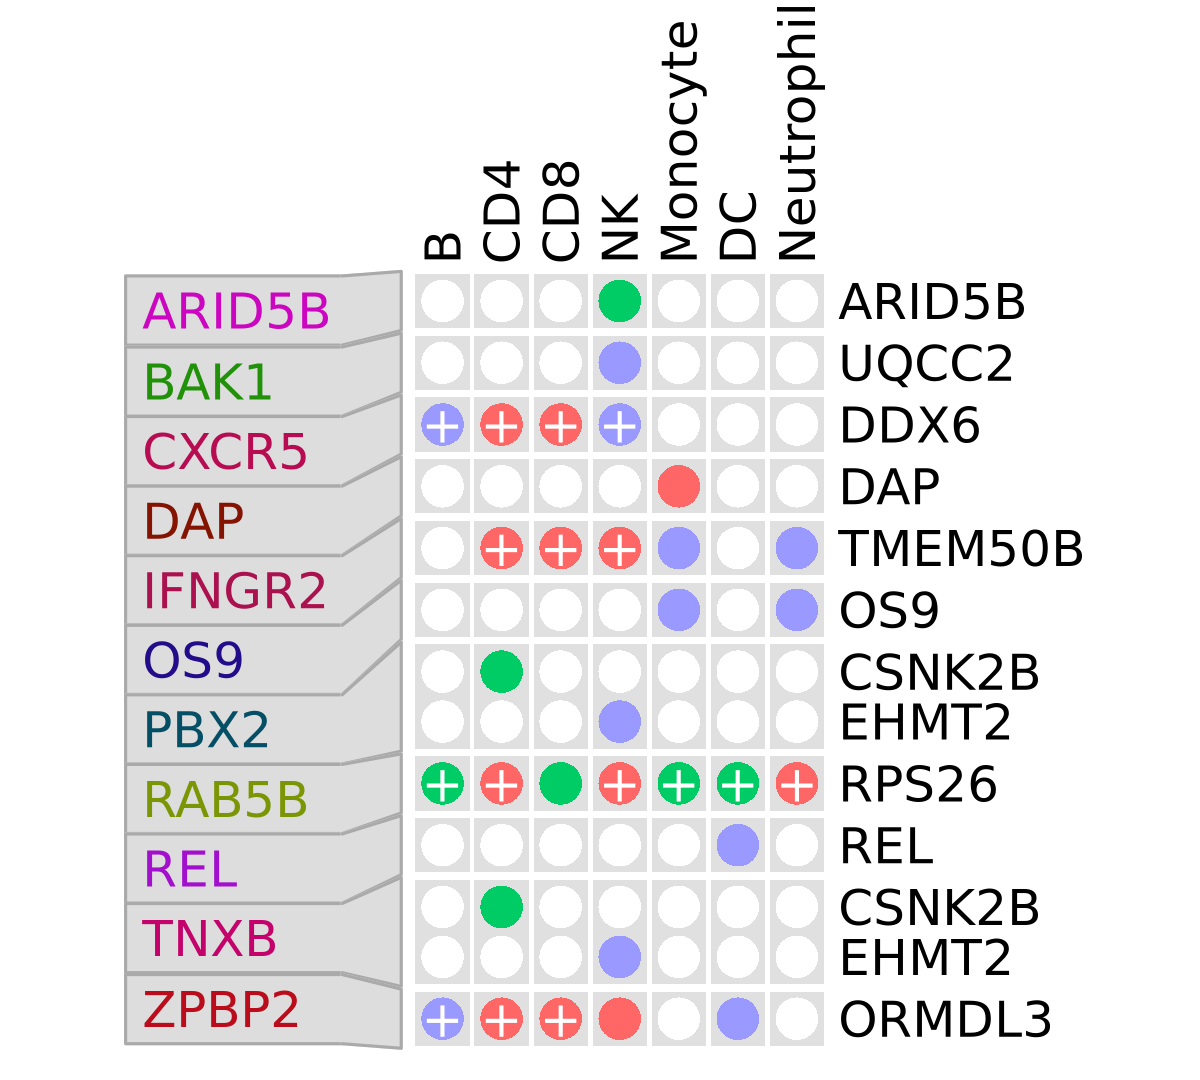

In [17]:
## hij=1e-4
mat_reorder = mat[,c(1,2,3,7,5,4,6)]
options(repr.matrix.max.cols=100, repr.matrix.max.rows=100)
options(repr.plot.width=4, repr.plot.height=3.6, repr.plot.res=300)
col_fun = colorRamp2(c(0, 1, 2, 3), c("grey", "red", "green", "blue"))
colors = structure(c("#FFFFFF", "#FF6666", "#00CC66", "#9999FF"), names = c(0,1,2,3))
text_color = '#FFFFFF'
split = eqtl_comb_sig_wide$closest_gene
text = as.list(unique(split))
names(text) = unique(split)
w = ncol(mat)*unit(5, "mm")
h = nrow(mat)*unit(5, "mm")
ht = Heatmap(mat_reorder, col=colors, rect_gp = gpar(type = "none"),
        cluster_rows = FALSE, cluster_columns = FALSE,
        cell_fun = function(j, i, x, y, width, height, fill) {
            c_idx = ifelse(mat_reorder[i,j]<10, mat_reorder[i, j]+1, as.integer(mat_reorder[i,j]/10)+1)
            grid.rect(x = x, y = y, width = unit(4.6, 'mm'), height = unit(4.6, 'mm'),
                     gp = gpar(fill = '#E0E0E0', col = NA))
           grid.circle(x = x, y = y, r = unit(1.8, "mm"), 
                gp = gpar(fill = colors[c_idx], col = NA))
            if(mat_reorder[i,j]>=10){
                grid.text('+', x=x, y=unit(as.numeric(y)*1, 'npc'), gp=gpar(col=text_color))
            }
           },
        right_annotation=rowAnnotation(labels = anno_text(eqtl_comb_sig_wide$symbol, which='row'), gp = gpar(fontsize = 8)),
        top_annotation=columnAnnotation(labels = anno_text(c(sorted_cell_names, 'Neutrophil'), 
                                                              which='column', just='left', location=unit(0, 'npc')), gp = gpar(fontsize = 10)),
         column_names_side = c("top"),
        row_title_gp = gpar(fontsize = 12),
        row_title_rot = 0,
       width = w, height = h,
       row_split=split,
        row_title=NULL,
        left_annotation = rowAnnotation(Locus = anno_textbox(split, text, side='left')),
       column_gap = unit(0, "mm"), border = FALSE,
       show_column_names=TRUE, show_heatmap_legend=FALSE,
       heatmap_legend_param = list(title='', 
                                   labels=c('Null', 'Shared', 'Only single cell', 'Only IBSEP'),
                                   grid_height = unit(5, "mm"), grid_width = unit(5, "mm"),
                                   labels_gp = gpar(fontsize = 14))
        )
draw(ht)